# Homework 3
### Daniela del Rio

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import scipy
from sklearn import mixture

# Part 1

In [2]:
SpikeWaveforms = np.load('SpikeWaveforms.npy', allow_pickle=True)
print(np.shape(SpikeWaveforms))
# AP detected, time, electrode

(33787, 40, 4)


In [3]:
indices = []
Peaks_1 = []
Peaks_2 = []
Peaks_3 = []
Peaks_4 = []
xn_ex2 = []

# Indices for starting and ending
start = 5
end = 25

for i in range(33787): #33787
    
    average_tetrodes = np.zeros(40)

    for time_i in range(40):
        average_tetrodes[time_i] = (np.sum(SpikeWaveforms[i,time_i,0]+SpikeWaveforms[i,time_i,1]+SpikeWaveforms[i,time_i,2]+SpikeWaveforms[i,time_i,3]))/4
        
    index = np.argmax(average_tetrodes)
    
    if start<index and index<end:
        indices.append(index)
        Peaks_1.append(SpikeWaveforms[i, index, 0])
        Peaks_2.append(SpikeWaveforms[i, index, 1])
        Peaks_3.append(SpikeWaveforms[i, index, 2])
        Peaks_4.append(SpikeWaveforms[i, index, 3])
        xn_ex2.append(SpikeWaveforms[i, :, 0])

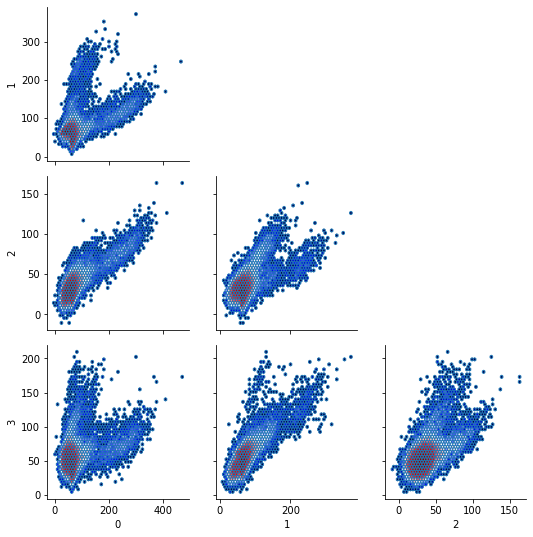

In [4]:
Peaks = [Peaks_1, Peaks_2, Peaks_3, Peaks_4]
Peaks = np.transpose(Peaks)

# Code from class website
PP = pd.DataFrame(np.array(Peaks))
g = sns.PairGrid(PP)
g = g.map_lower(plt.hexbin,gridsize=50, mincnt=1, cmap='seismic',bins='log')
for i, j in zip(*np.triu_indices_from(g.axes, 0)):
    g.axes[i, j].set_visible(False)

# Part 2
## Clustering with K-means

In [5]:
def iterative_cost_function(xns, mk, rnks): # Cost function for 1 cluster
    n = len(xns)
    J = 0
    for i in range(n):
        if rnks[i]: 
            J += np.sum((xns[i]-mk)**2) #Sums all 40 values
    return J

def all_clusters_cost_function(xns, mks, rnks): # Cost function for all clusters
    J = 0
    
    for cluster_i in range(len(mks)):
        J+= iterative_cost_function(xns, mks[cluster_i], rnks[cluster_i])
    return J

In [6]:
# Assigning a cluster based on distance between centroids and points:
def distances(xns, mks):
    number_of_clusters = len(mks) #2000
    number_of_datapoints = len(xns) #3
    
    rnks_1 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_2 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_3 = np.zeros(number_of_datapoints, dtype = bool)
    
    for i in range(number_of_datapoints):
        distance = np.zeros(number_of_clusters)
        
        for cluster_i in range(number_of_clusters):
            distance[cluster_i]= np.sum((xns[i]-mks[cluster_i])**2)
            
        minimum = np.argmin(distance)
        
        if minimum ==0: # Belongs in cluster 1
            rnks_1[i] = 1
        elif minimum ==1: # Belongs in cluster 2
            rnks_2[i] = 1
        elif minimum ==2: # Belongs in cluster 3
            rnks_3[i] = 1
    return rnks_1, rnks_2, rnks_3

In [7]:
def plot_traces(xns, rnks_1, rnks_2, rnks_3, mks):
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(10,7))
    fig.suptitle('Neuron traces based on cluster', fontsize=20)

    time = [i for i in range(40)]
    for i in range(2000):

        if rnks_1[i]:
            ax1.plot(time, xns[i], marker="o", color="salmon")

        elif rnks_2[i]:
            ax2.plot(time, xns[i], marker="o", color="deeppink")

        elif rnks_3[i]:
            ax3.plot(time, xns[i], marker="o", color="dimgrey")

    ax1.plot(time, mks[0], marker ="o", c="r")
    ax2.plot(time, mks[1], marker ="o", c="purple")
    ax3.plot(time, mks[2], marker ="o", c="k")
    plt.xlabel('Time')
    plt.ylabel("Voltage")
    plt.show()
    return None

In [8]:
# Updating centroids
def updates_centroids(xns, rnks_1, rnks_2, rnks_3):
    c1 = []
    c2 = []
    c3 = []

    for i in range(2000):

        if rnks_1[i]:
            c1.append(xns[i])

        elif rnks_2[i]:
            c2.append(xns[i])

        elif rnks_3[i]:
            c3.append(xns[i])

    mks1 = np.mean(c1, 0)
    mks2 = np.mean(c2, 0)
    mks3 = np.mean(c3, 0)
    
    return mks1, mks2, mks3 

In [9]:
def one_iteration(xns, mks_init):
    rnks_1, rnks_2, rnks_3 = distances(xns, mks_init)
    mks1, mks2, mks3 = updates_centroids(xns, rnks_1, rnks_2, rnks_3)
    
    mks = [mks1, mks2, mks3]
    rnks = [rnks_1, rnks_2, rnks_3]
    
    J = all_clusters_cost_function(xns, mks, rnks)
    return J, rnks, mks

In [20]:
xns = xn_ex2[:2000] # whole 40 time indices of electrode 1

# Initializes with 3 random traces from the dataset
mks_init = [xns[round(2000*random.random())], xns[round(2000*random.random())], xns[round(2000*random.random())]]
J = np.zeros(20)

J[0], rnks_1, mks = one_iteration(xns, mks_init) # First iteration

for i in range(1,20):
    J[i], rnks, mks = one_iteration(xns, mks)

### Part a

First clusters


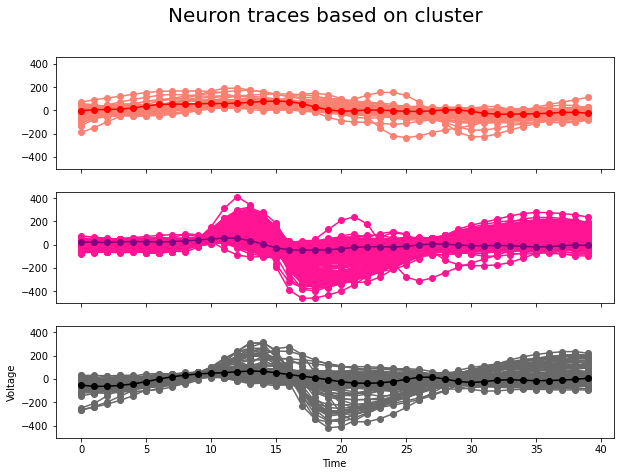

Last clusters


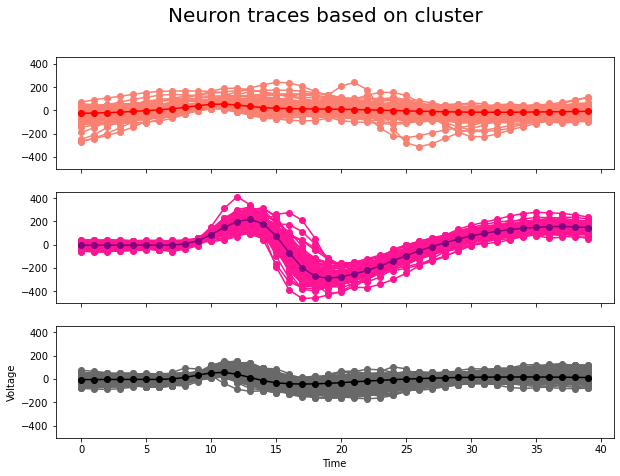

In [11]:
print("First clusters")
plot_traces(xns, rnks_1[0], rnks_1[1], rnks_1[2], mks_init)

print("Last clusters")
plot_traces(xns, rnks[0], rnks[1], rnks[2], mks)

### Part b

If we draw a horizontal line which corresponds to the last value of J (the converginf J value), this is reached in iteration 3 to 5 of the K-means algorithm. It changes in this interval because we are starting with a different neronal trace each trial.

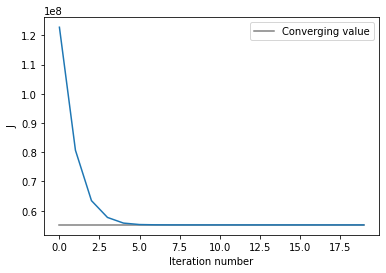

In [21]:
plt.plot([0,19], [J[19], J[19]], label = "Converging value", color = "grey")
plt.plot(J)
plt.xlabel("Iteration number")
plt.ylabel("J")
plt.legend()
plt.show()

# Programa algo donde se vea la convergencia. Y determina el promedio donde converge esta J.

How many iterations did it take for K-Means to converge?

### Part c
Using 4 clusters.

In [13]:
# Assigning a cluster based on distance between centroids and points:
def distances_4(xns, mks):
    number_of_clusters = len(mks) #2000
    number_of_datapoints = len(xns) #3
    
    rnks_1 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_2 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_3 = np.zeros(number_of_datapoints, dtype = bool)
    rnks_4 = np.zeros(number_of_datapoints, dtype = bool)
    
    for i in range(number_of_datapoints):
        distance = np.zeros(number_of_clusters)
        
        for cluster_i in range(number_of_clusters):
            distance[cluster_i]= np.sum((xns[i]-mks[cluster_i])**2)
            
        minimum = np.argmin(distance)
        
        if minimum ==0: # Belongs in cluster 1
            rnks_1[i] = 1
        elif minimum ==1: # Belongs in cluster 2
            rnks_2[i] = 1
        elif minimum ==2: # Belongs in cluster 3
            rnks_3[i] = 1
        elif minimum ==3: # Belongs in cluster 3
            rnks_4[i] = 1
    return rnks_1, rnks_2, rnks_3, rnks_4

def plot_traces_4(xns, rnks_1, rnks_2, rnks_3, rnks_4, mks):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True, figsize=(10,7))
    fig.suptitle('Neuron traces based on cluster', fontsize=20)

    time = [i for i in range(40)]
    for i in range(2000):

        if rnks_1[i]:
            ax1.plot(time, xns[i], marker="o", color="salmon")

        elif rnks_2[i]:
            ax2.plot(time, xns[i], marker="o", color="deeppink")

        elif rnks_3[i]:
            ax3.plot(time, xns[i], marker="o", color="dimgrey")

        elif rnks_4[i]:
            ax4.plot(time, xns[i], marker="o", color="lightblue")

    ax1.plot(time, mks[0], marker ="o", c="r")
    ax2.plot(time, mks[1], marker ="o", c="purple")
    ax3.plot(time, mks[2], marker ="o", c="k")
    ax4.plot(time, mks[3], marker ="o", c="b")
    plt.xlabel('Time')
    plt.ylabel("Voltage")
    plt.show()
    return None

# Updating centroids
def updates_centroids_4(xns, rnks_1, rnks_2, rnks_3, rnks_4):
    c1 = []
    c2 = []
    c3 = []
    c4 = []

    for i in range(2000):

        if rnks_1[i]:
            c1.append(xns[i])

        elif rnks_2[i]:
            c2.append(xns[i])

        elif rnks_3[i]:
            c3.append(xns[i])

        elif rnks_4[i]:
            c4.append(xns[i])

    mks1 = np.mean(c1, 0)
    mks2 = np.mean(c2, 0)
    mks3 = np.mean(c3, 0)
    mks4 = np.mean(c4, 0)
    
    return mks1, mks2, mks3, mks4

def one_iteration_4(xns, mks_init):
    rnks_1, rnks_2, rnks_3, rnks_4 = distances_4(xns, mks_init)
    mks1, mks2, mks3, mks4 = updates_centroids_4(xns, rnks_1, rnks_2, rnks_3, rnks_4)
    
    mks = [mks1, mks2, mks3, mks4]
    rnks = [rnks_1, rnks_2, rnks_3, rnks_4]
    
    J = all_clusters_cost_function(xns, mks, rnks)
    return J, rnks, mks

In [14]:
# Update for using 4 centroids

xns = xn_ex2[:2000] # whole 40 time indices of electrode 1

# Initializes with 3 random traces from the dataset
mks_init = [xns[round(2000*random.random())], xns[round(2000*random.random())], xns[round(2000*random.random())], xns[round(2000*random.random())]]
J = np.zeros(20)

J[0], rnks_1, mks = one_iteration_4(xns, mks_init) # First iteration

for i in range(1,20):
    J[i], rnks, mks = one_iteration_4(xns, mks)

First clusters


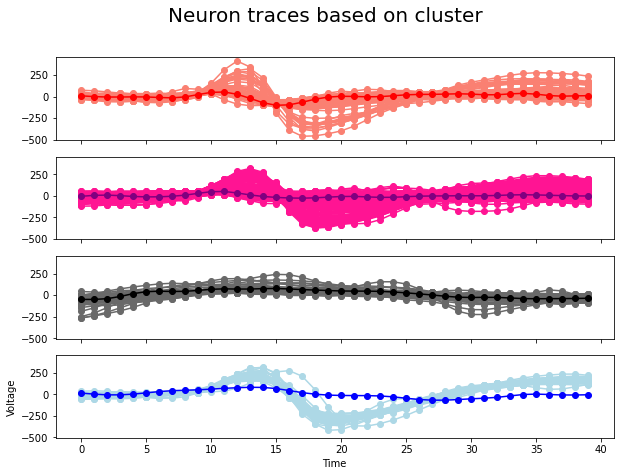

Last clusters


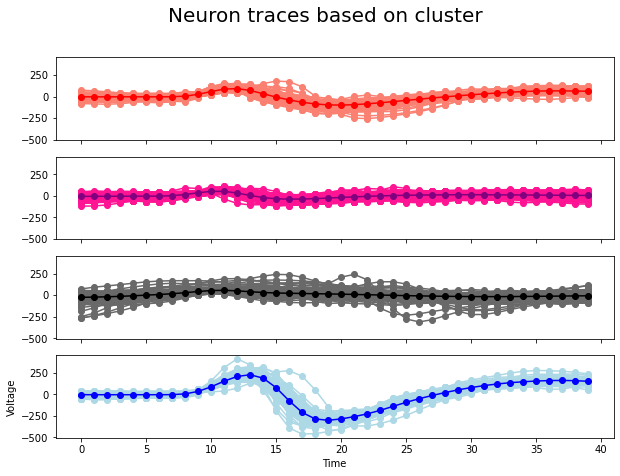

In [15]:
print("First clusters")
plot_traces_4(xns, rnks_1[0], rnks_1[1], rnks_1[2], rnks[3], mks_init)

print("Last clusters")
plot_traces_4(xns, rnks[0], rnks[1], rnks[2], rnks[3], mks)

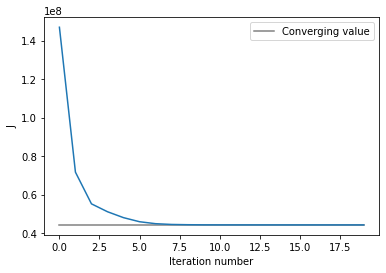

In [16]:
plt.plot([0,19], [J[19], J[19]], label = "Converging value", color = "grey")
plt.plot(J)
plt.xlabel("Iteration number")
plt.ylabel("J")
plt.legend()
plt.show()

# Stop iterating when cost function does not change or when the assignments don't change

https://en.wikipedia.org/wiki/K-means_clustering

https://quick-adviser.com/how-do-you-implement-k-means/

# Part 4
## Using Gaussian mixtures

In [17]:
# Code from homework assignment
gmix = mixture.GaussianMixture(n_components=2, covariance_type='full')
gmix.fit(Peaks)

GaussianMixture(n_components=2)

# Part 5
## Clustering using Pearson Correlation